In [1]:
import pandas as pd
import geopandas
import json
from shapely.geometry import Point
import folium
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)


# Analyse comparative des quantités de points d'arrêts

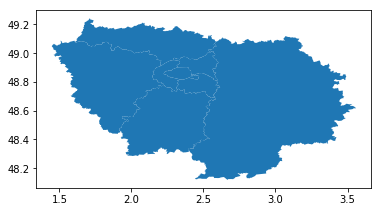

In [2]:
#contenus géographiques qu'on utilisera
zones = geopandas.read_file('ref_data/idf_departements.geojson', driver='GeoJSON')
zones = zones[['name', 'geometry']]
zones.plot()

In [3]:
#on charge les données
osm_stoppoints = pd.read_csv("../data/osm-transit-extractor_stop_points.csv", dtype=str)
gtfs_stoppoints = pd.read_csv("../data/gtfs_stops.txt", dtype=str)
gtfs_stoppoints = gtfs_stoppoints[gtfs_stoppoints['location_type'] == '0'] #on retire les zones d'arrêts

#on ajoute la dimension géographique
crs = {'init': 'epsg:4326'}
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['stop_lon']),float(row['stop_lat']))

gtfs_stoppoints['geometry'] = gtfs_stoppoints.apply(gtfs_lat_lon_to_geom, axis=1)
gtfs_stoppoints.drop('stop_lon', axis=1, inplace=True)
gtfs_stoppoints.drop('stop_lat', axis=1, inplace=True)

def osm_lat_lon_to_geom(row):
    return Point(float(row['lon']),float(row['lat']))

osm_stoppoints['geometry'] = osm_stoppoints.apply(osm_lat_lon_to_geom, axis=1)
osm_stoppoints.drop('lon', axis=1, inplace=True)
osm_stoppoints.drop('lat', axis=1, inplace=True)

osm_stops_geo = geopandas.GeoDataFrame(osm_stoppoints, crs=crs, geometry=osm_stoppoints.geometry)
gtfs_stops_geo = geopandas.GeoDataFrame(gtfs_stoppoints, crs=crs, geometry=gtfs_stoppoints.geometry)

#on calcule le nombre par département
gtfs_stoppoints_with_zones = geopandas.sjoin(gtfs_stops_geo, zones.copy(), op='within')
counts_gtfs_stops = gtfs_stoppoints_with_zones.groupby('name').size()
zones_with_gtfs_stops_count = zones[['name', 'geometry']].merge(counts_gtfs_stops.reset_index(name='nb_stoppoints_officiel'))

osm_stoppoints_with_zones = geopandas.sjoin(osm_stops_geo, zones.copy(), op='within')
counts_osm_stops = osm_stoppoints_with_zones.groupby('name_right').size()
zones_with_stoppoints_count = zones_with_gtfs_stops_count.merge(counts_osm_stops.reset_index(name='nb_stoppoints_osm'), left_on="name", right_on='name_right')
zones_with_stoppoints_count.drop('name_right', axis=1, inplace=True)

#on calcule le pourcentage de couverture d'OSM par rapport à l'officiel
zones_with_stoppoints_count["couverture_stoppoints_osm"] = zones_with_stoppoints_count["nb_stoppoints_osm"] * 100.0 / zones_with_stoppoints_count["nb_stoppoints_officiel"]

zones_with_stoppoints_count


,name,geometry,nb_stoppoints_officiel,nb_stoppoints_osm,couverture_stoppoints_osm
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",8299,4591,55.319918
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",4032,2586,64.136905
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",5919,3680,62.172664
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",4765,2981,62.560336
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",3740,2772,74.117647
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",8332,3969,47.635622
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",3158,2690,85.180494
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",3054,2402,78.650950


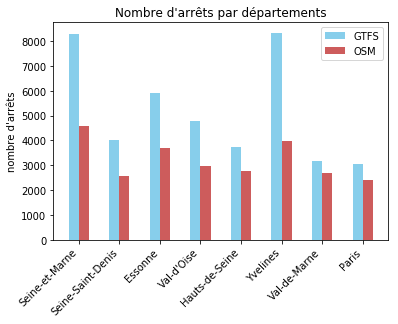

In [4]:
#histogramme de la couverture en pourcentage par département
width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, zones_with_stoppoints_count["nb_stoppoints_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_stoppoints_count["nb_stoppoints_osm"], 
                width, color='IndianRed', label='OSM')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('nombre d\'arrêts')
ax.set_title('Nombre d\'arrêts par départements')
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_stoppoints_count["name"], rotation=45, ha='right')
ax.legend()


In [5]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_stoppoints_count, data=zones_with_stoppoints_count, columns=['name', 'couverture_stoppoints_osm'],
             key_on='feature.properties.name', fill_color='YlOrRd', highlight=True)


m

Pourcentage de couverture global sur l'Île-de-France en points d'arrêts:

In [6]:
len(osm_stoppoints) * 100.0 / len(gtfs_stoppoints)

61.630390439394304

NB : les données OSM sont déjà filtrées sur les bus, mais pas les données officielles

# Analyse comparative en utilisant les lignes desservies

In [7]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv("../data/gtfs_routes.txt", dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv("../data/osm-transit-extractor_lines.csv", dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

Pourcentage de couverture en lignes de bus:

In [8]:
len(osm_lines) * 100.0 / len(gtfs_lines)

49.75013881177124

In [9]:
#préparation géographique des données officielles pour les routepoints
gtfs_routepoints = pd.read_csv("../data/opendata_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
crs = {'init': 'epsg:4326'}   
def gtfs_lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(gtfs_lat_lon_to_geom, axis=1)

gtfs_geo = geopandas.GeoDataFrame(gtfs_routepoints, crs=crs, geometry=gtfs_routepoints.geometry)
#gtfs_geo.plot(markersize=0.5, figsize=(10, 10))

gtfs_routepoints_with_zones = geopandas.sjoin(gtfs_geo, zones.copy(), op='within')
counts_gtfs = gtfs_routepoints_with_zones.groupby('name').size()
zones_with_gtfs_count = zones.merge(counts_gtfs.reset_index(name='nb_stops_officiel'))

In [10]:
#préparation géographique des données OSM pour les routepoints
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)
def osm_lat_lon_to_geom(row):
    return Point(float(row['osm_lon']),float(row['osm_lat']))

osm_routepoints['geometry'] = osm_routepoints.apply(osm_lat_lon_to_geom, axis=1)
osm_routepoints.drop('osm_lon', axis=1, inplace=True)
osm_routepoints.drop('osm_lat', axis=1, inplace=True)

osm_geo = geopandas.GeoDataFrame(osm_routepoints, crs=crs, geometry=osm_routepoints.geometry)
#osm_geo.plot(markersize=0.5, figsize=(10, 10))

osm_routepoints_with_zones = geopandas.sjoin(osm_geo, zones.copy(), op='within')
counts_osm = osm_routepoints_with_zones.groupby('name').size()
zones_with_routepoints_count = zones_with_gtfs_count.merge(counts_osm.reset_index(name='nb_stops_osm'))
zones_with_routepoints_count["couverture_osm"] = zones_with_routepoints_count["nb_stops_osm"] * 100.0 / zones_with_routepoints_count["nb_stops_officiel"]

zones_with_routepoints_count

,name,geometry,nb_stops_officiel,nb_stops_osm,couverture_osm
0,Seine-et-Marne,"POLYGON ((3.0294998 48.2855332, 3.029456 48.28...",26168,3576,13.665546
1,Seine-Saint-Denis,"POLYGON ((2.5535179 49.0101078, 2.5553387 49.0...",8409,2276,27.066239
2,Essonne,"POLYGON ((2.233067 48.766197, 2.233127 48.7662...",14250,3661,25.691228
3,Val-d'Oise,"POLYGON ((2.0236394 48.9979223, 2.0233612 48.9...",10282,3270,31.803151
4,Hauts-de-Seine,"POLYGON ((2.2908192 48.9510806, 2.291703 48.95...",7787,3739,48.015924
5,Yvelines,"POLYGON ((1.6089984 49.0777846, 1.6097927 49.0...",22114,1781,8.053722
6,Val-de-Marne,"POLYGON ((2.4163604 48.8492351, 2.4166794 48.8...",7585,3412,44.983520
7,Paris,"POLYGON ((2.3301825 48.9010281, 2.334615 48.90...",6828,4454,65.231400


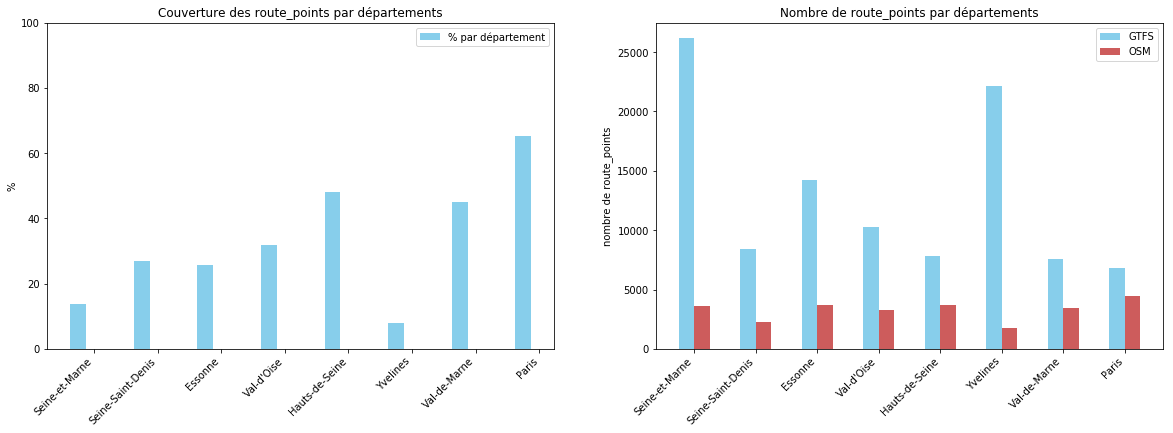

In [11]:
# histogramme de la couverture en pourcentage par département
width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
fig = plt.figure(figsize=(20, 6))
# 1er graph
ax = fig.add_subplot(121)
rects = ax.bar(ind - width, zones_with_routepoints_count["couverture_osm"], 
                width, color='SkyBlue', label='% par département')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Couverture des route_points par départements')
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_stoppoints_count["name"], rotation=45, ha='right')
ax.legend()

# 2eme graph
ax = fig.add_subplot(122)
width = 0.25  # the width of the bars
ind = np.arange(zones.shape[0])
rects1 = ax.bar(ind - width/2, zones_with_routepoints_count["nb_stops_officiel"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, zones_with_routepoints_count["nb_stops_osm"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('nombre de route_points')
ax.set_title('Nombre de route_points par départements')
ax.set_xticks(ind)
ax.set_xticklabels(zones_with_stoppoints_count["name"], rotation=45, ha='right')
ax.legend()




In [12]:
m = folium.Map([48.8566, 2.3429], zoom_start=9, tiles="OpenStreetMap")
m.choropleth(geo_data=zones_with_routepoints_count, data=zones_with_routepoints_count, columns=['name', 'couverture_osm'],
             key_on='feature.properties.name', fill_color='YlGn', highlight=True)


m

Pourcentage global de couverture OSM sur l'Île-de-France en routepoints : 

In [13]:
len(osm_routepoints) * 100.0 / len(gtfs_routepoints)

25.161488772685328

In [14]:
#TODO : nombre moyen de terminus par ligne, pour OSM

#TODO : nombre moyen de terminus par ligne, pour le GTFS

# Analyse quantitative par réseau

TODO : faire une table de correspondance entre les réseaux des deux sources car on en écarte plus de la moitié parce que ça ne matche pas exactement

Et trouver un moyen sympa de le visualiser

In [15]:
osm_networks = pd.DataFrame(osm_routepoints.groupby('osm_network').size()).reset_index()
osm_networks.rename(columns={0: 'osm_routepoints_count'}, inplace=True)
gtfs_networks = pd.DataFrame(gtfs_routepoints.groupby('gtfs_agency_name').size()).reset_index()
gtfs_agency_line_count = gtfs_routepoints.groupby('gtfs_agency_name').gtfs_route_short_name.nunique().reset_index()
gtfs_networks = gtfs_networks.merge(gtfs_agency_line_count, how='left', on='gtfs_agency_name')
gtfs_networks.rename(columns={0: 'gtfs_routepoints_count', "gtfs_route_short_name":"gtfs_lines_count"}, inplace=True)
networks = gtfs_networks.merge(osm_networks, how='inner', right_on=['osm_network'], left_on=['gtfs_agency_name'])
networks.drop('osm_network', axis=1, inplace=True)
networks['osm_couverture'] = networks['osm_routepoints_count'] * 100.0 / networks['gtfs_routepoints_count']
networks.head()


,gtfs_agency_name,gtfs_routepoints_count,gtfs_lines_count,osm_routepoints_count,osm_couverture
0,Apolo 7,946,7,192,20.295983
1,Arlequin,1054,8,77,7.305503
2,Autobus du Fort,45,3,11,24.444444
3,Aérial,637,9,52,8.163265
4,Bus en Seine,945,13,33,3.492063


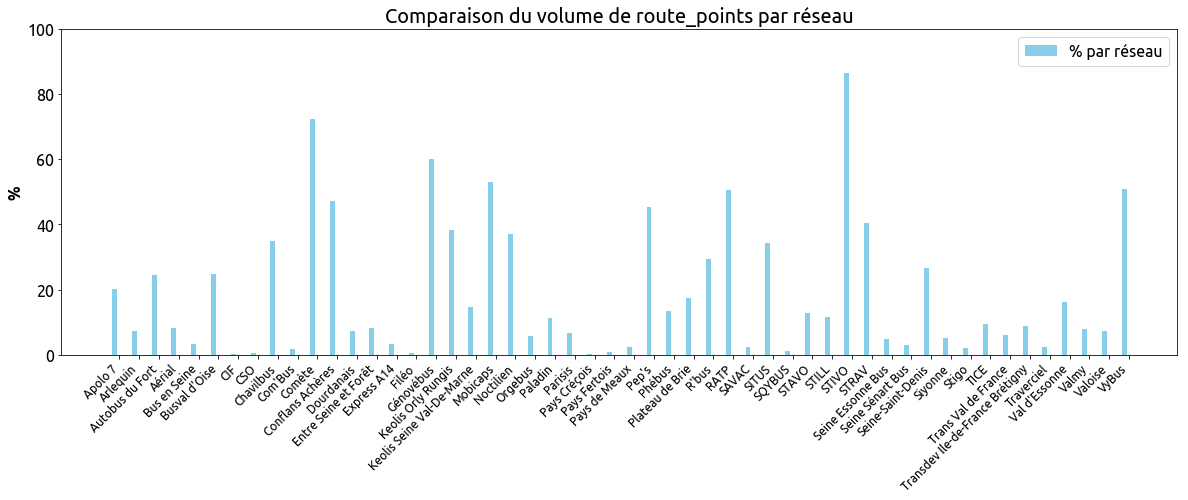

In [30]:
width = 0.25  # the width of the bars
ind = np.arange(networks.shape[0])
fig, ax = plt.subplots(figsize=(20, 6))
rects = ax.bar(ind - width, networks['osm_couverture'], 
                width, color='SkyBlue', label='% par réseau')
ax.set_ylim(0, 100)
ax.set_ylabel('%')
ax.set_title('Comparaison du volume de route_points par réseau')
ax.set_xticks(ind)
ax.set_xticklabels(networks["gtfs_agency_name"], rotation=45, ha='right')
ax.legend()


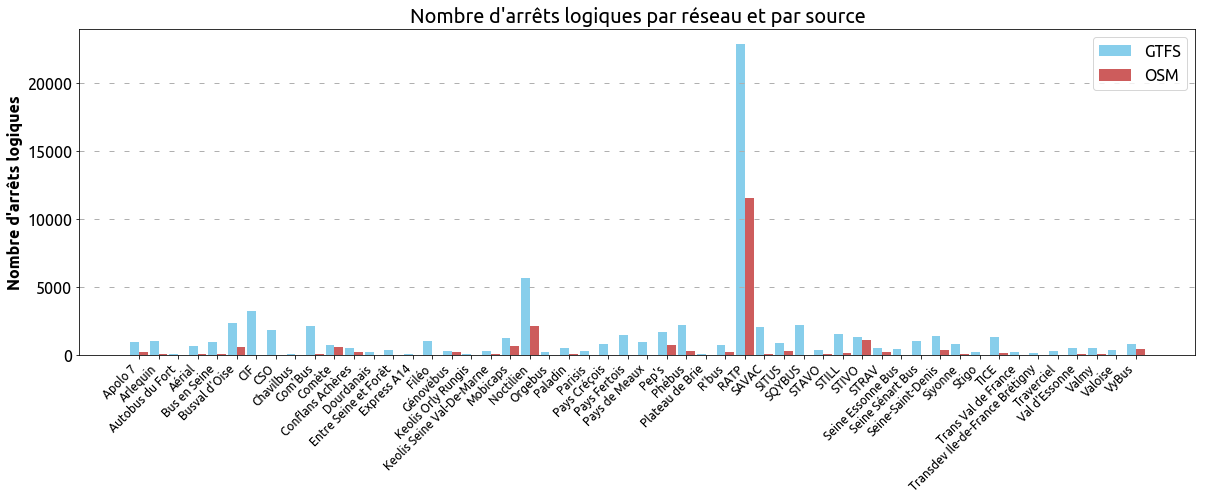

In [17]:
# la première ligne fait un reset du style 
mpl.rcParams.update(inline_rc)
# plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
width = 0.45  # the width of the bars
ind = np.arange(networks.shape[0])

fig, ax = plt.subplots(figsize=(20, 6))
rects1 = ax.bar(ind - width/2, networks["gtfs_routepoints_count"], 
                width, color='SkyBlue', label='GTFS')
rects2 = ax.bar(ind + width/2, networks["osm_routepoints_count"], 
                width, color='IndianRed', label='OSM')
ax.set_ylabel('Nombre d\'arrêts logiques')
ax.set_title('Nombre d\'arrêts logiques par réseau et par source')
ax.set_xticks(ind)
ax.set_xticklabels(networks["gtfs_agency_name"], rotation=45, ha='right')
ax.grid(linestyle=(0, (5, 10)), axis='y', linewidth=1)

ax.legend()

# Analyse qualitative

uniquement sur les données où les référentiels d'Île-de-France ont été intégrés

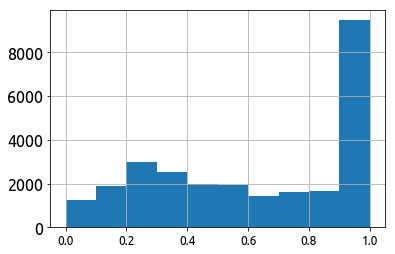

In [18]:
osm_routepoints = pd.read_csv("../data/osm_routepoints_for_matching.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints.fillna("", inplace=True)
gtfs_routepoints = gtfs_routepoints[gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
routepoints = gtfs_routepoints.merge(
                    osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
routepoints.fillna("", inplace=True)

def compute_similarity_for_terminus(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
routepoints['destination_confidence'] = routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_for_terminus(*x), axis=1)
routepoints['destination_confidence'].hist()

In [19]:
routepoints = routepoints[routepoints['destination_confidence'] >= 0.6]

NB : le matching sur les terminus est loin d'être parfait. Pour de meilleurs résultats, il faudrait :
* soit un référentiel officiel des parcours (qui pourrait être importé dans les données OSM)
* soit établir un tableau de correspondance entre les terminus

(cf quelques contrexemples ci-dessous)

In [20]:
difflib.SequenceMatcher(None, 'A. Lebrun', '').ratio() #0
difflib.SequenceMatcher(None, 'Sucy-Bonneuil RER', 'Gare de Sucy-Bonneuil').ratio() # 0.68
difflib.SequenceMatcher(None, 'Cimetière', 'Cimetière de Saint-Maur-des-Fossés').ratio() #0.41
difflib.SequenceMatcher(None, 'A. Lebrun', 'Auguste Lebrun').ratio() #0.69
difflib.SequenceMatcher(None, 'Saint-Maur Créteil', 'SAINT-MAUR - CRETEIL RER').ratio() #0.23
difflib.SequenceMatcher(None, 'Saint-Maur Créteil'.lower(), 'SAINT-MAUR - CRETEIL RER'.lower()).ratio() #0.80

difflib.SequenceMatcher(None, 'Gare de Laplace (Arcueil)', 'Arcueil Laplace RER').ratio() # 0.5
difflib.SequenceMatcher(None, 'Noisy-le-Roi - Centre Commercial le Cèdre', 'Centre commercial').ratio() #0.55
difflib.SequenceMatcher(None, 'Massy', 'Gare RER Massy Palaiseau').ratio() #0.34
difflib.SequenceMatcher(None, 'Gare de La Verrière', 'LA VERRIERE NOCTILIEN'.lower()).ratio() #0.4

0.4

## Mesures qualitatives

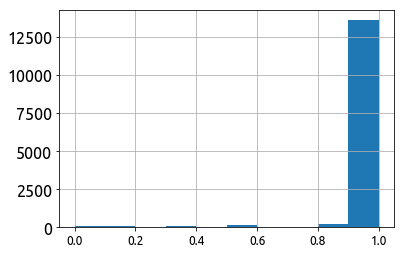

In [21]:
# différences sur les codes de ligne
routepoints['line_code_confidence'] = routepoints[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['line_code_confidence'].hist()

In [22]:
routepoints_ = routepoints[routepoints['line_code_confidence'] < 0.8]
routepoints_ = routepoints_[['gtfs_route_short_name', 'osm_code']]
grouped = routepoints_.groupby(['gtfs_route_short_name', 'osm_code'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df

,gtfs_route_short_name,osm_code
10294,DIRECT 4,Direct 4
26499,TRAVERSE,Traverse
8658,RE,RÉ
21182,CHARONN,501
21240,V1,v1
0,CEN,Centaure
9516,Tzen1,TZen 1
21202,NAVETTE,524
21192,BIEVRES,513
10184,CITA,Citalien


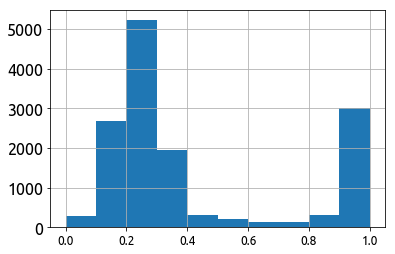

In [23]:
# différences sur les noms des arrêts
routepoints['name_confidence'] = routepoints[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
routepoints['name_confidence'].hist()

In [24]:
routepoints_ = routepoints[routepoints['name_confidence'] < 0.5]
routepoints_ = routepoints_[['gtfs_stop_name', 'osm_name']]
grouped = routepoints_.groupby(['gtfs_stop_name', 'osm_name'])
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
unique_df = routepoints_.reindex(index)
unique_df.head()

,gtfs_stop_name,osm_name
13122,SQUARE DES BATIGNOLLES,Square des Batignolles
10367,REPUBLIQUE - TEMPLE,République - Temple
17682,FORT D'IVRY,Fort d'Ivry
13527,RICHARD LENOIR,Richard Lenoir
10084,MONTDAUPHIN,Montdauphin


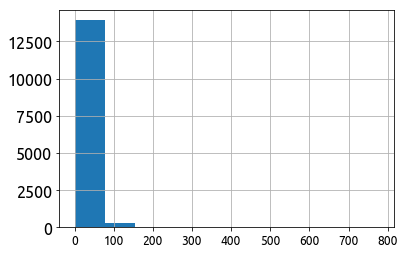

In [25]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
routepoints['distance'] = routepoints.apply(compute_distance, axis=1)

routepoints['distance'].hist()
#TODO : trouver une meilleure représentation graphique qui montre que 
#l'essentiel est en dessous de 50 m, mais qu'il y a des points bien bien loin
# ptet une boite à moustache ?

In [26]:
routepoints['distance'].mean()

17.949333809586136

In [27]:
routepoints_ = routepoints[routepoints['distance'] > 80]
len(routepoints_)

352

In [28]:
routepoints_ = routepoints_.sort_values(by='distance') 
#TODO : trouver un moyen sympa de visualiser ces écarts de distance
routepoints_

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,...,osm_network,osm_name,osm_osm:ref:FR:STIF,osm_route_id,osm_lon,osm_stop_id,destination_confidence,line_code_confidence,name_confidence,distance
18776,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,RATP,Cousin de Méricourt,28582,Route:Relation:1259521,2.3332596,StopPoint:Node:979833097,0.636364,1.000000,0.210526,80.228791
18431,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,RATP,Cousin de Méricourt,28582,Route:Relation:1991745,2.3332596,StopPoint:Node:979833097,0.800000,1.000000,0.210526,80.228791
18430,StopPoint:59:7275415,100100162:162,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,VAL FLEURY RER,162,RATP,...,RATP,Cousin de Méricourt,28582,Route:Relation:1991745,2.3332596,StopPoint:Node:979833097,0.800000,1.000000,0.210526,80.228791
18777,StopPoint:59:7275415,100100184:184,28582,COUSIN DE MERICOURT,48.797097,2.333831,1,PASTEUR,184,RATP,...,RATP,Cousin de Méricourt,28582,Route:Relation:1259521,2.3332596,StopPoint:Node:979833097,0.636364,1.000000,0.210526,80.228791
14371,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,HOTEL DE VILLE,74,RATP,...,RATP,Brochant - Cardinet,24603,Route:Relation:1253892,2.3179000999999997,StopPoint:Node:596079812,0.928571,1.000000,0.263158,80.289990
12131,StopPoint:59:4016293,100100054:54,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PORTE D'AUBERVILLIERS,54,RATP,...,RATP,Brochant - Cardinet,24603,Route:Relation:1257179,2.3179000999999997,StopPoint:Node:596079812,1.000000,1.000000,0.263158,80.289990
14364,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,PLACE DE CLICHY,74,RATP,...,RATP,Brochant - Cardinet,24603,Route:Relation:7925363,2.3179000999999997,StopPoint:Node:596079812,1.000000,1.000000,0.263158,80.289990
23500,StopPoint:59:4016293,100987782:N15,24603,BROCHANT - CARDINET,48.891322,2.318669,1,VILLEJUIF - LOUIS ARAGON-METRO,N15,Noctilien,...,Noctilien,Brochant - Cardinet,24603,Route:Relation:1537047,2.3179000999999997,StopPoint:Node:596079812,0.851852,1.000000,0.263158,80.289990
14370,StopPoint:59:4016293,100100074:74,24603,BROCHANT - CARDINET,48.891322,2.318669,1,HOTEL DE VILLE,74,RATP,...,RATP,Brochant - Cardinet,24603,Route:Relation:1253892,2.3179000999999997,StopPoint:Node:596079812,0.928571,1.000000,0.263158,80.289990
23499,StopPoint:59:4016293,100987782:N15,24603,BROCHANT - CARDINET,48.891322,2.318669,1,VILLEJUIF - LOUIS ARAGON-METRO,N15,Noctilien,...,Noctilien,Brochant - Cardinet,24603,Route:Relation:1537047,2.3179000999999997,StopPoint:Node:596079812,0.851852,1.000000,0.263158,80.289990
